In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Decision Tree
from sklearn import tree

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier

from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset_folder_path = "/content/drive/My Drive/Colab/Machine Learning/Datasets/loan_eligibility_data/"
train_csv = dataset_folder_path + "train.csv"
test_csv = dataset_folder_path + "test.csv"
sample_submission = dataset_folder_path + "sample_submission.csv"

train_original = pd.read_csv(train_csv)
test_original = pd.read_csv(test_csv)
ss = pd.read_csv(sample_submission)

In [ ]:
print(train_original.shape)
print(test_original.shape)
print(ss.shape)

(614, 13)
(367, 12)
(367, 2)


Again, like all Kaggle competition, the test file given does not have any labels, so we cannot evaluate our performance on that set. Instead, what we will do is split the train set into a train and test set in order to evaluate the performance of our models. We will finally use the given test set for submission.

In [ ]:
train_data, test_data = train_test_split(train_original, test_size=0.2, random_state=42)

**EDA**

In [ ]:
print(train_data.shape)
print(test_data.shape)

(491, 13)
(123, 13)


In [ ]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
83,LP001273,Male,Yes,0,Graduate,No,6000,2250.0,265.0,360.0,NaN,Semiurban,N
90,LP001316,Male,Yes,0,Graduate,No,2958,2900.0,131.0,360.0,1.0,Semiurban,Y
227,LP001758,Male,Yes,2,Graduate,No,6250,1695.0,210.0,360.0,1.0,Semiurban,Y
482,LP002537,Male,Yes,0,Graduate,No,2083,3150.0,128.0,360.0,1.0,Semiurban,Y
464,LP002493,Male,No,0,Graduate,No,4166,0.0,98.0,360.0,0.0,Semiurban,N


In [ ]:
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 83 to 102
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             479 non-null    object 
 2   Married            490 non-null    object 
 3   Dependents         480 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      467 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         475 non-null    float64
 9   Loan_Amount_Term   479 non-null    float64
 10  Credit_History     451 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 53.7+ KB


There are some missing values, but not too many that we are not able to continue exploring the data. We will go on with visualizing and understanding the data before imputing the missing values.

# Splitting data into different dtypes

In [ ]:
train_df_obj = train_data.select_dtypes(include='object', exclude=['int64', 'float64'])
train_df_obj

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
83,LP001273,Male,Yes,0,Graduate,No,Semiurban,N
90,LP001316,Male,Yes,0,Graduate,No,Semiurban,Y
227,LP001758,Male,Yes,2,Graduate,No,Semiurban,Y
482,LP002537,Male,Yes,0,Graduate,No,Semiurban,Y
464,LP002493,Male,No,0,Graduate,No,Semiurban,N
...,...,...,...,...,...,...,...,...
71,LP001245,Male,Yes,2,Not Graduate,Yes,Semiurban,Y
106,LP001369,Male,Yes,2,Graduate,No,Urban,Y
270,LP001888,Female,No,0,Graduate,No,Urban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,Semiurban,Y


In [ ]:
train_df_obj.columns.unique().to_list()

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [ ]:
for col in train_df_obj.columns:
  if col != "Loan_ID":
    print(col, ": ", train_df_obj[col].unique())


Gender :  ['Male' nan 'Female']
Married :  ['Yes' 'No' nan]
Dependents :  ['0' '2' '3+' '1' nan]
Education :  ['Graduate' 'Not Graduate']
Self_Employed :  ['No' 'Yes' nan]
Property_Area :  ['Semiurban' 'Rural' 'Urban']
Loan_Status :  ['N' 'Y']


In [ ]:
train_df_num = train_data.select_dtypes(include=['int64', 'float64'], exclude=['object'])
train_df_num

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
83,6000,2250.0,265.0,360.0,NaN
90,2958,2900.0,131.0,360.0,1.0
227,6250,1695.0,210.0,360.0,1.0
482,2083,3150.0,128.0,360.0,1.0
464,4166,0.0,98.0,360.0,0.0
...,...,...,...,...,...
71,1875,1875.0,97.0,360.0,1.0
106,11417,1126.0,225.0,360.0,1.0
270,3237,0.0,30.0,360.0,1.0
435,10047,0.0,NaN,240.0,1.0


Now we will go through each variable and look at their plots. Starting with categorical(object) features

# Gender

In [ ]:
train_df_obj.columns.unique().to_list()

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

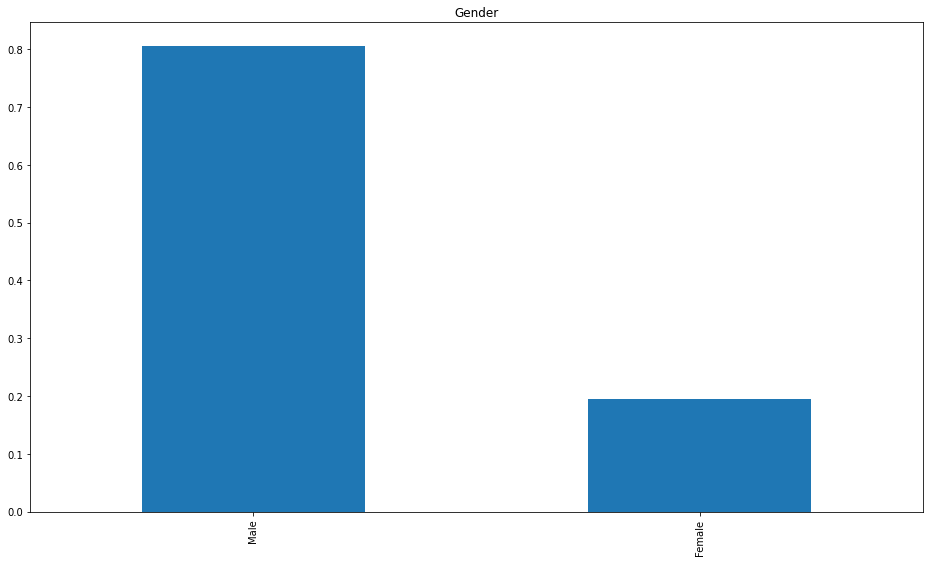

In [ ]:
train_df_obj['Gender'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Gender')

An easy misunderstanding is that most loans are approved for males, but this plot merely tells us there are more males (80%) than females (20%) in our dataset and does NOT tell us anything about the higher eligibility of male applicants for loans. 

# Married

Assumption_1: Married applicants would have higher loan eligibility chances.


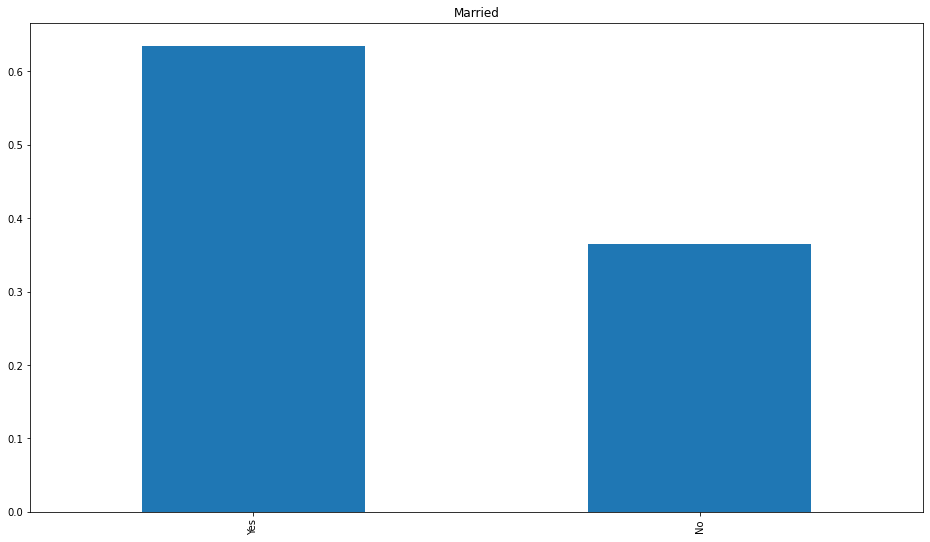

In [ ]:
train_df_obj['Married'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Married')

Similarly, there are more married applicants (65%) than unmarried applicants (35%) in our dataset. 

[ASSUMPTION_1] One hypothesis could be that married applicants would get higher loan eligibility.

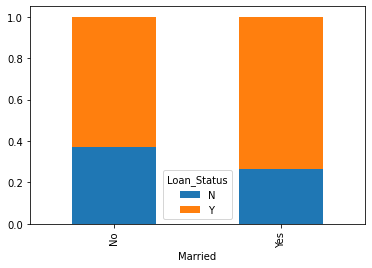

In [ ]:
married_loan_status = pd.crosstab(train_data['Married'], train_data['Loan_Status'])
married_loan_status.div(married_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

Hence, we can say the hypothesis stands true as there is a slightly larger percentage of married applicants with loan approvals.

# Dependents

ASSUMPTION_2: Applicants with less dependents would get higher loan eligibility.

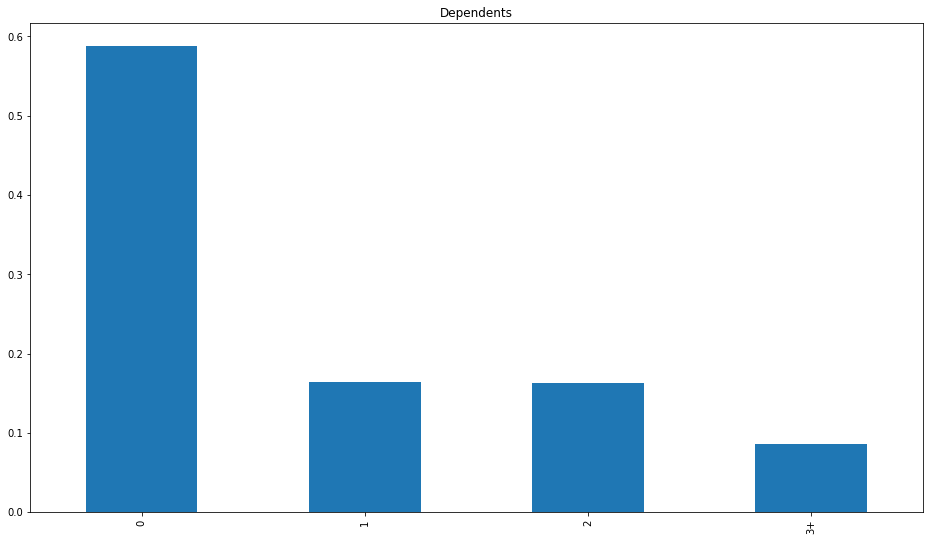

In [ ]:
train_df_obj['Dependents'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Dependents')

Majority of the applicants in our dataset has 0 dependents. 

[ASSUMPTION_2] Applicants with less dependents, if all else is constant, would get higher loan eligibility as most of the income can go towards repayment. But this only stands true if all other parameters stay constant. Unlikely.

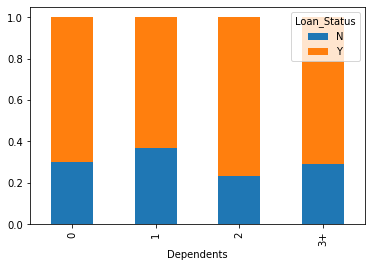

In [ ]:
dependents_loan_status = pd.crosstab(train_data['Dependents'], train_data['Loan_Status'])
dependents_loan_status.div(dependents_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

From the bar plot above, it seems that applicants with 0 or 2 dependents tend to have higher percentage of loan approvals. This is a little weird as there is little explanation/assumptions that can made as to why applicants with 1 dependent have lower percentage of loan approvals compared to applicants with 2 dependents.

# Education

Assumption_3: Graduates have higher loan eligibility chances than non-graduates.

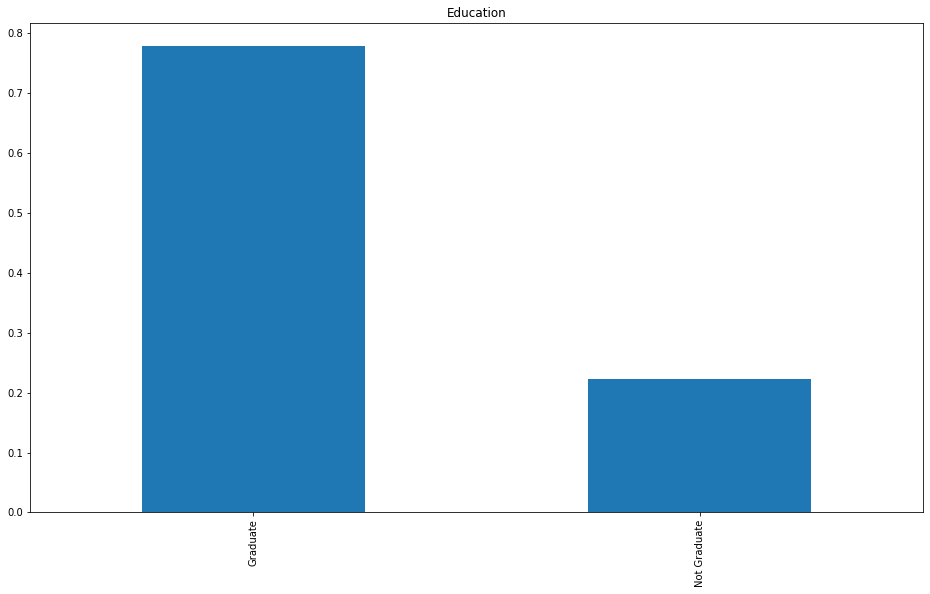

In [ ]:
train_df_obj['Education'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Education')

More graduates than non-graduates apply for loans in our dataset. 

[ASSUMPTION] We could theorize that graduates get higher loan chances than non-graduates, since they are part of the working class and are able to repay the loans.

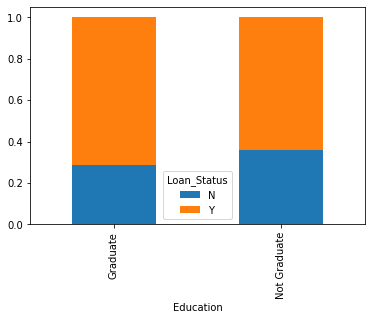

In [ ]:
education_loan_status = pd.crosstab(train_data['Education'], train_data['Loan_Status'])
education_loan_status.div(education_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

We can see graduates have higher loan approvals compared to non-graduates.

# Self_Employed

Assumption_4: There is no difference in the loan eligibility for both self-employed and non-self-employed working people.

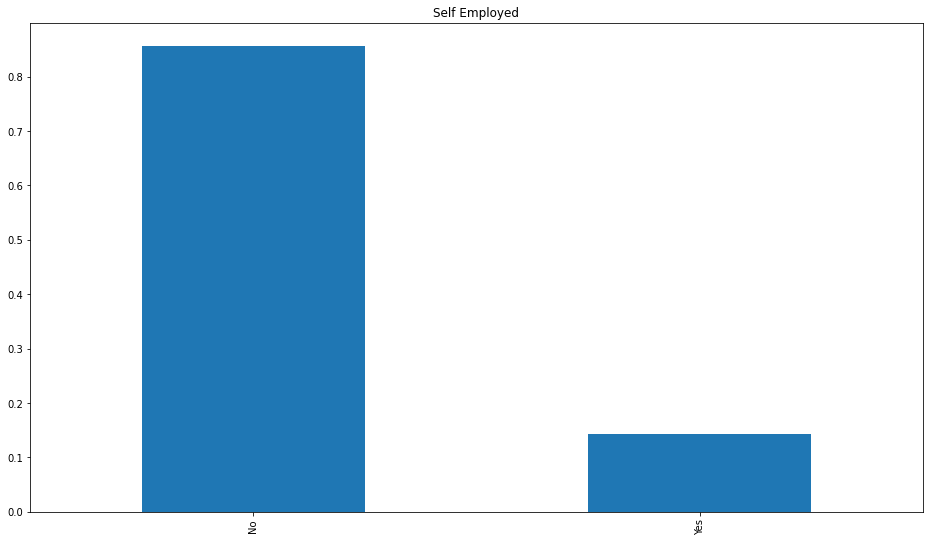

In [ ]:
train_df_obj['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Self Employed')

Majority (more than 80%) are NOT self-employed, meaning most of our applicants in our dataset are working for employers/companies. 

[ASSUMPTION] My theory is that there is no difference in the loan status between these two working groups as long as there is income.

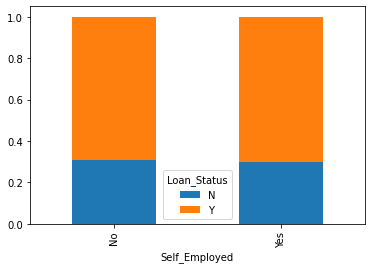

In [ ]:
self_employed_loan_status = pd.crosstab(train_data['Self_Employed'], train_data['Loan_Status'])
self_employed_loan_status.div(self_employed_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

Exactly my point.

# Property_Area

Assumption_5: Applicants living in the semiurban or urban area have higher loan eligibility.

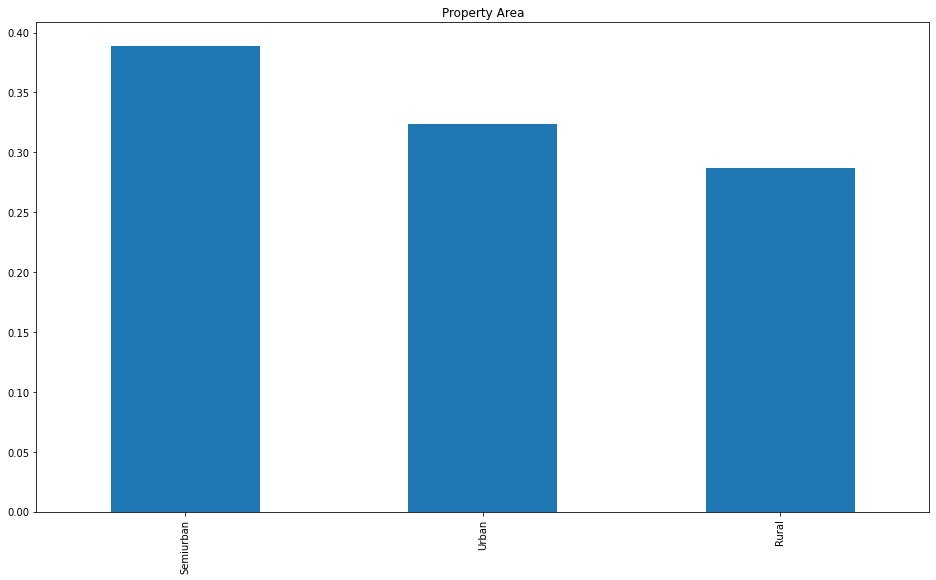

In [ ]:
train_df_obj['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Property Area')

Most of the applicants live in the semiurban areas, followed by urban and then rural areas.

[ASSUMPTION] One could say that loan applicants staying in semiurban/urban areas would get higher loan eligibility than those in rural areas, simply because of the average income.

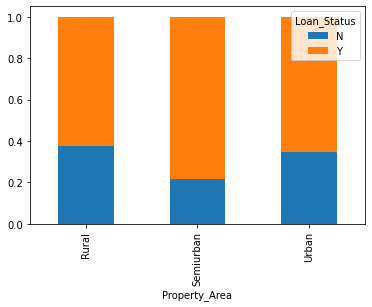

In [ ]:
property_area_loan_status = pd.crosstab(train_data['Property_Area'], train_data['Loan_Status'])
property_area_loan_status.div(property_area_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

Like the plot suggests, applicants who live in the semiurban/urban areas tend to have higher percentage of loan approvals compared to those who stay at rural areas.

# Loan Status

No assumptions.

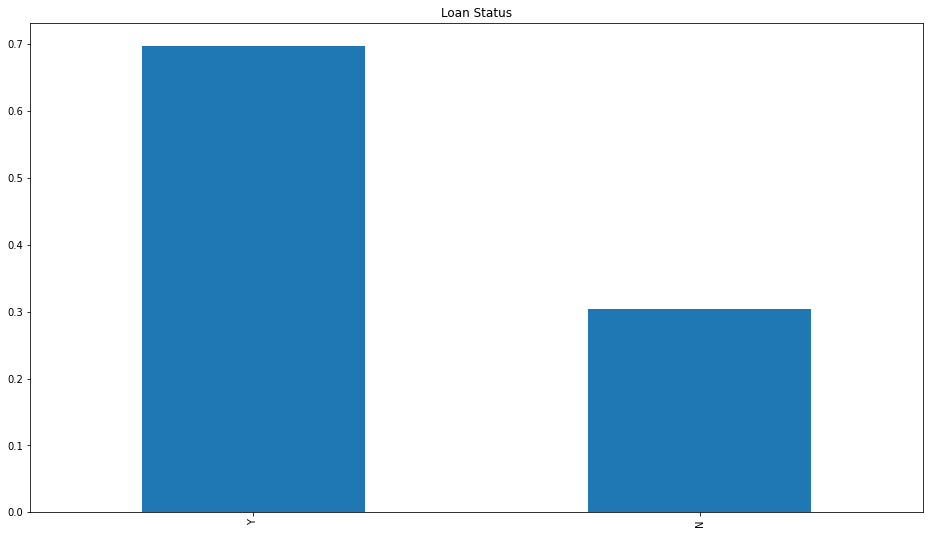

In [ ]:
train_df_obj['Loan_Status'].value_counts(normalize=True).plot.bar(figsize=(16, 9), title='Loan Status')

More applicants get a green light on their loan status at about 65%.

# Numerical Features

In [ ]:
train_df_num.columns.to_list()

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

# Applicant Income and Coapplicant Income

Assumption_6: Applicants of higher income tend to have higher loan eligibility.

Assumption_7: Self-employed applicants have higher income, hence higher loan eligibility.

Assumption_8: Applicants who are graduates have higher income, hence higher loan eligibility.

Assumption_9: Coapplicants with higher income tend to help the applicants to have higher loan eligibility.

Assumption_10: The total income combining income from applicants and coapplicants tend to determine the loan eligibility. Higher total income equals higher loan eligibility.

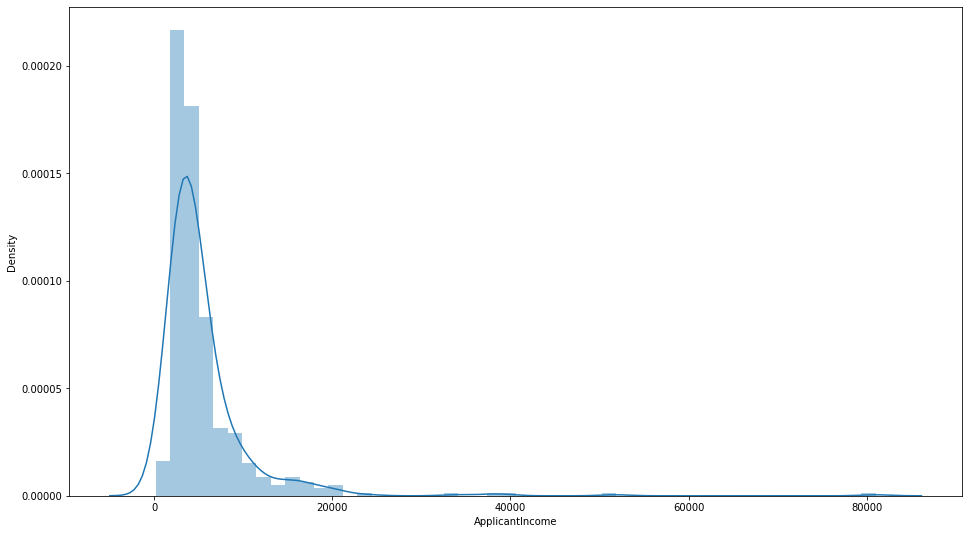

In [ ]:
plt.figure(figsize=(16, 9))
sns.distplot(train_df_num['ApplicantIncome'])

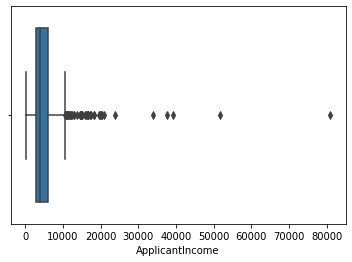

In [ ]:
sns.boxplot(x='ApplicantIncome', data=train_df_num)

The plot makes sense as income usually is skewed to the right with the majority of the income within the same range. The distribution of the income is positively skewed. We will have to fix the skewness later.

But which categorical feature can we relate ApplicantIncome to? 
- Self-employed
- Education

It would be interesting to explore the two features above relating to ApplicantIncome. Let's do that.

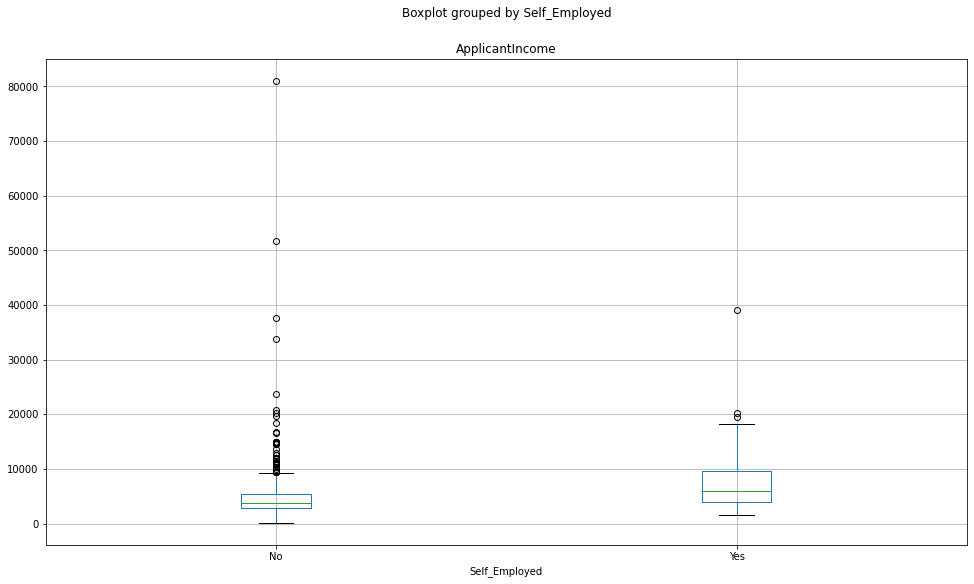

In [ ]:
train_data.boxplot(column='ApplicantIncome', by='Self_Employed', figsize=(16, 9))

There is quite a number of outliers or extreme values for non-self-employed applicants. It seems the outliers are earning far more than the self-employed people, although the median income for self-employed is higher than non-self-employed.

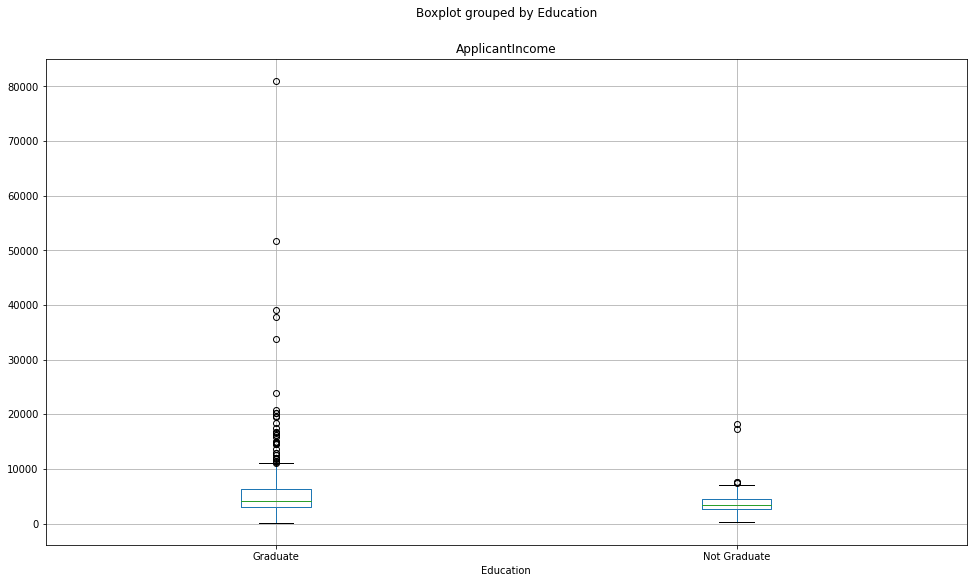

In [ ]:
train_data.boxplot(column='ApplicantIncome', by='Education', figsize=(16, 9))

This plot solidifies our theory that graduates earn more than non-graduates, but there are too many outliers for income from the graduates.

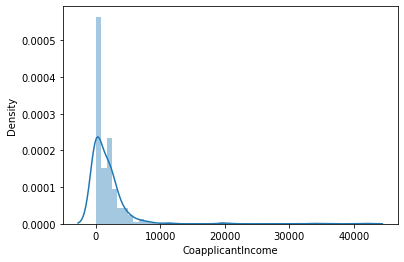

In [ ]:
sns.distplot(train_df_num['CoapplicantIncome'])

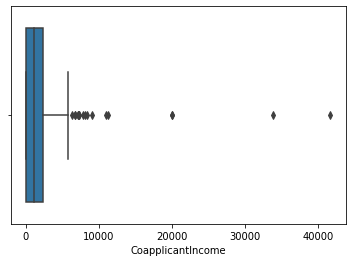

In [ ]:
sns.boxplot(train_data['CoapplicantIncome'])

Similar to the ApplicantIncome, it is positively skewed. But one interesting question is how much weight does this feature have on our target, considering there is the ApplicantIncome feature? Let's compare the ApplicantIncome with Loan Status and CoapplicantIncome with Loan Status.

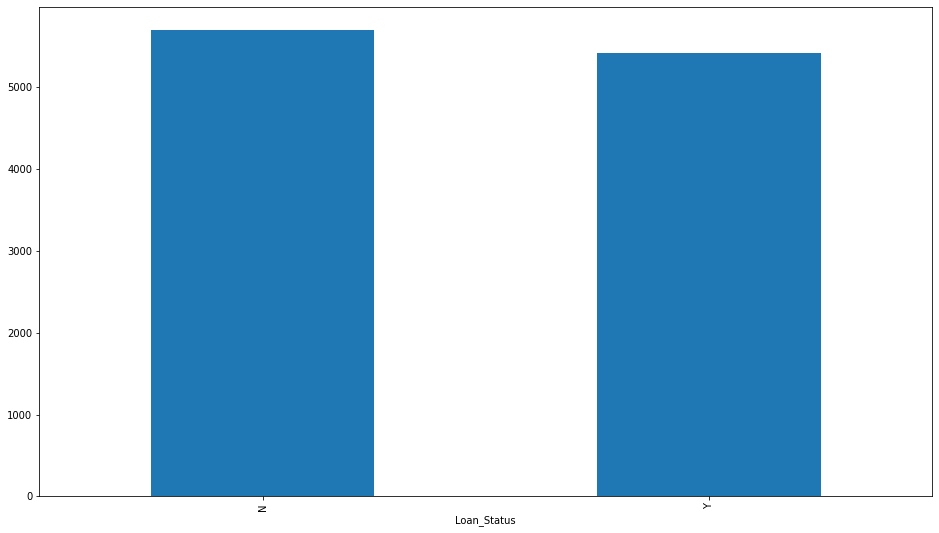

In [ ]:
train_data.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar(figsize=(16, 9))

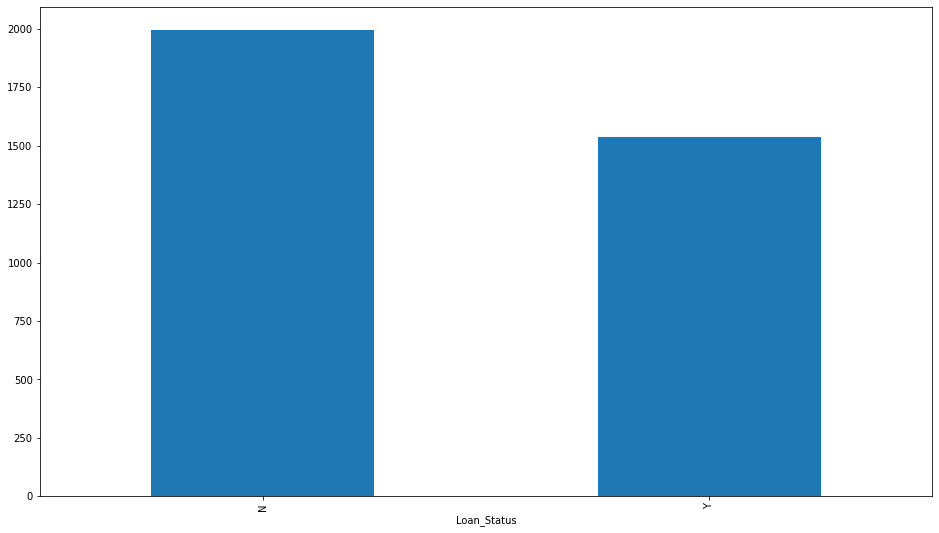

In [ ]:
train_data.groupby('Loan_Status')['CoapplicantIncome'].mean().plot.bar(figsize=(16, 9))

So, it seems from our first plot, the mean income for those who are rejected a loan is the same as those who are given a loan. This does not tell us much about whether a person's income dictate the loan eligibility. Let's plot another graph to see more clearly. We will separate into bins the income.

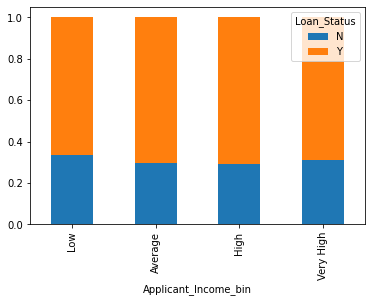

In [ ]:
bins = [0, 2000, 4000, 6000, 80000]
groups = ['Low', 'Average', 'High', 'Very High']
train_data['Applicant_Income_bin'] = pd.cut(train_data['ApplicantIncome'], bins, labels=groups)

# Use pd.crosstab when comparing two categorical features
applicant_income_bin_loan_status = pd.crosstab(train_data['Applicant_Income_bin'], train_data['Loan_Status'])
applicant_income_bin_loan_status.div(applicant_income_bin_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

This plot does not tell us anything newer too, the loan eligibility across all income categories look similar. Let's do the same for CoaaplicantIncome.

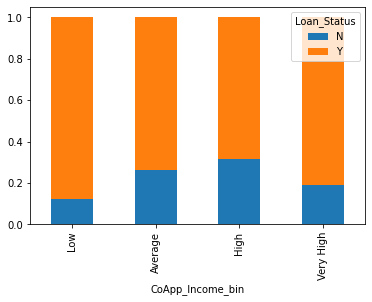

In [ ]:
bins = [0, 1000, 3000, 5000, 10000]
groups = ['Low', 'Average', 'High', 'Very High']
train_data['CoApp_Income_bin'] = pd.cut(train_data['CoapplicantIncome'], bins, labels=groups)

# Use pd.crosstab when comparing two categorical features
coapplicant_income_bin_loan_status = pd.crosstab(train_data['CoApp_Income_bin'], train_data['Loan_Status'])
coapplicant_income_bin_loan_status.div(coapplicant_income_bin_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

To explain the graph, there's a higher percentage of loan eligibility with status Y for coapplicants of low income. Contradicting!

One question arises: What if there are applicants who apply loans without any coapplicants? Does it go under 0 for CoapplicantIncome?

Let's try to answer this by combining both ApplicantIncome and CoapplicantIncome.

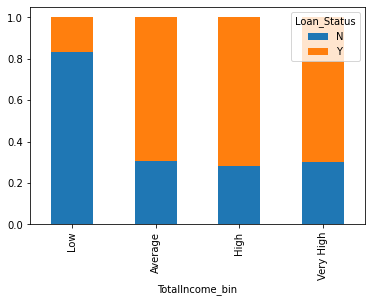

In [ ]:
train_data['TotalIncome'] = train_data['ApplicantIncome'] + train_data['CoapplicantIncome']

bins = [0, 2000, 4000, 6000, 80000]
groups = ['Low', 'Average', 'High', 'Very High']
train_data['TotalIncome_bin'] = pd.cut(train_data['TotalIncome'], bins, labels=groups)

# Use pd.crosstab when comparing two categorical features
total_income_loan_status = pd.crosstab(train_data['TotalIncome_bin'], train_data['Loan_Status'])
total_income_loan_status.div(total_income_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

In [ ]:
test_data['TotalIncome'] = test_data['ApplicantIncome'] + test_data['CoapplicantIncome']

Ahh this makes much more sense. The total income for applicants(applicants+coapplicants) determines the loan status based on this plot. When the total income is low, there is a higher percentage of loan rejection.

We will use this feature instead of the ApplicantIncome and CoapplicantIncome.

Let's continue with our data exploration.

# Loan Amount

Assumption_11: Applicants who apply for bigger loan amounts have lower loan eligibility.

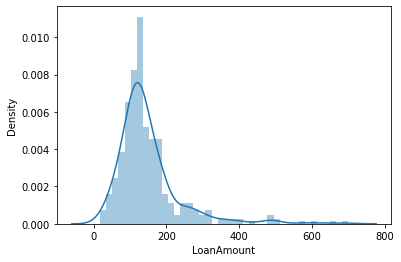

In [ ]:
sns.distplot(train_data['LoanAmount'])

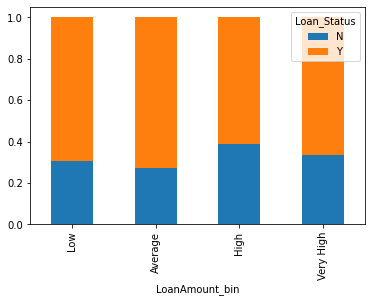

In [ ]:
bins = [0, 100, 200, 400, 800]
groups = ['Low', 'Average', 'High', 'Very High']
train_data['LoanAmount_bin'] = pd.cut(train_data['LoanAmount'], bins, labels=groups)

# Use pd.crosstab when comparing two categorical features
loan_amount_loan_status = pd.crosstab(train_data['LoanAmount_bin'], train_data['Loan_Status'])
loan_amount_loan_status.div(loan_amount_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

Although not very distinct, loan approvals are higher for low and average loan amounts.

# Loan Amount Term

Assumption_12: Applicants who opt for a longer loan amount term have low loan eligibility.

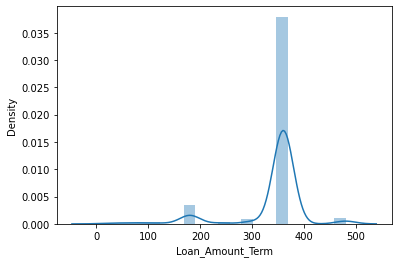

In [ ]:
sns.distplot(train_data['Loan_Amount_Term'])

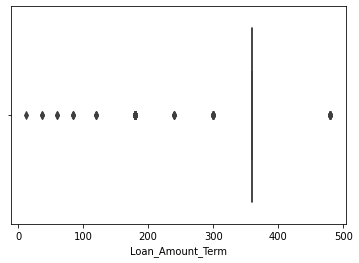

In [ ]:
sns.boxplot(x='Loan_Amount_Term', data=train_df_num)

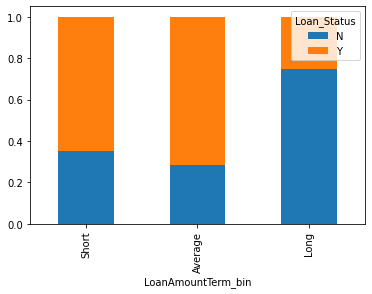

In [ ]:
bins = [0, 200, 400, 500]
groups = ['Short', 'Average', 'Long']
train_data['LoanAmountTerm_bin'] = pd.cut(train_data['Loan_Amount_Term'], bins, labels=groups)

# Use pd.crosstab when comparing two categorical features
loan_amount_term_loan_status = pd.crosstab(train_data['LoanAmountTerm_bin'], train_data['Loan_Status'])
loan_amount_term_loan_status.div(loan_amount_term_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

Okay, it makes sense that for loan amount terms that are shorter, the loan approval percentages are higher.

# Credit History

Assumption_13: Applicants who have a credit history, regardless of a good or bad credit history, have higher loan eligibility.

In [ ]:
train_df_num['Credit_History'].value_counts()

1.0    381
0.0     70
Name: Credit_History, dtype: int64

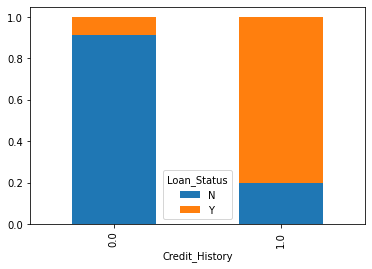

In [ ]:
credit_history_loan_status = pd.crosstab(train_data['Credit_History'], train_data['Loan_Status'])
credit_history_loan_status.div(credit_history_loan_status.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

Applicants with a credit history, regardless of whether it is a good or bad record, will have higher chances of getting a loan.



---



# Correlation map

In [ ]:
print(train_df_obj.columns)
print(train_df_num.columns)
print(train_data.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Applicant_Income_bin', 'CoApp_Income_bin', 'TotalIncome',
       'TotalIncome_bin', 'LoanAmount_bin', 'LoanAmountTerm_bin'],
      dtype='object')


In [ ]:
# We will drop the bins features that we created earlier for data exploration
train_data.drop(['Applicant_Income_bin', 'CoApp_Income_bin', 'TotalIncome_bin', 'LoanAmount_bin', 'LoanAmountTerm_bin'], axis='columns', inplace=True)
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'TotalIncome'],
      dtype='object')

First, we transform the Loan_Status in our train_data to numerical values of 0 and 1 before looking at the correlation map.

In [ ]:
train_df_obj['Loan_Status'].value_counts()

Y    342
N    149
Name: Loan_Status, dtype: int64

In [ ]:
train_data['Loan_Status'].replace('N', 0, inplace=True)
train_data['Loan_Status'].replace('Y', 1, inplace=True)
train_data['Loan_Status'].value_counts()

1    342
0    149
Name: Loan_Status, dtype: int64

In [ ]:
test_data['Loan_Status'].replace('N', 0, inplace=True)
test_data['Loan_Status'].replace('Y', 1, inplace=True)

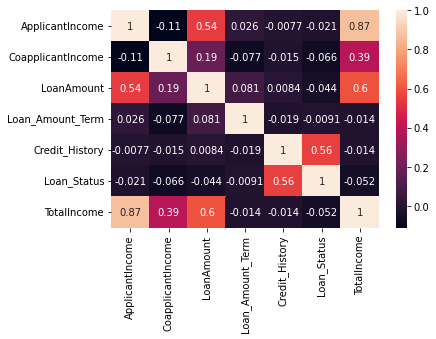

In [ ]:
corr = train_data.corr()
sns.heatmap(corr, annot=True, cmap='rocket')

We can see that the Loan_Amount is highly correlated to ApplicantIncome, TotalIncome to ApplicantIncome, CoapplicantIncome and Loan_Amount. Credit_History is very correlated to the Loan_Status.

Although TotalIncome is highly correlated to both ApplicantIncome and CoapplicantIncome, the issue of multicollinearity is less complex in classification problems, hence we will try to keep TotalIncome for now.

# Handling missing data

In [ ]:
train_df_num = train_data.select_dtypes(include=['int64', 'float64'], exclude=['object'])
train_df_obj = train_data.select_dtypes(include=['object'], exclude=['int64', 'float64'])

In [ ]:
train_df_num.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'TotalIncome'],
      dtype='object')

In [ ]:
train_df_obj.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

In [ ]:
total_null = train_df_num.isnull().sum().sort_values(ascending=False)
percent_null = (train_df_num.isnull().sum() / train_df_num.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent
Credit_History,40,0.081466
LoanAmount,16,0.032587
Loan_Amount_Term,12,0.024440


In [ ]:
train_df_num['Credit_History'].value_counts()

1.0    381
0.0     70
Name: Credit_History, dtype: int64

Remember Credit_History is a categorical feature with values of 0 and 1

In [ ]:
train_df_num['Credit_History'].fillna(train_df_num['Credit_History'].mode()[0], inplace=True)
print(train_df_num['Credit_History'].isnull().sum())

0


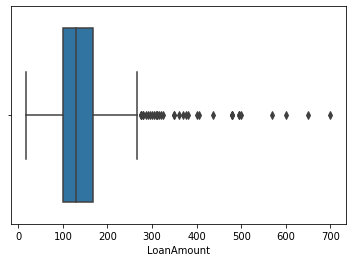

In [ ]:
sns.boxplot(train_df_num['LoanAmount'])

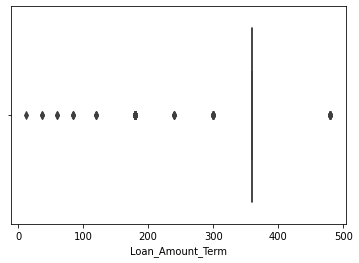

In [ ]:
sns.boxplot(train_df_num['Loan_Amount_Term'])

We will impute these empty values with the median

In [ ]:
train_df_num['LoanAmount'].fillna(train_df_num['LoanAmount'].median(), inplace=True)
train_df_num['Loan_Amount_Term'].fillna(train_df_num['Loan_Amount_Term'].median(), inplace=True)

In [ ]:
total_null = train_df_num.isnull().sum().sort_values(ascending=False)
percent_null = (train_df_num.isnull().sum() / train_df_num.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


In [ ]:
total_null = train_df_obj.isnull().sum().sort_values(ascending=False)
percent_null = (train_df_obj.isnull().sum() / train_df_obj.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent
Self_Employed,24,0.048880
Gender,12,0.024440
Dependents,11,0.022403
Married,1,0.002037


Let's impute the missing values with the mode

In [ ]:
train_df_obj['Self_Employed'].fillna(train_df_obj['Self_Employed'].mode()[0], inplace=True)
train_df_obj['Gender'].fillna(train_df_obj['Gender'].mode()[0], inplace=True)
train_df_obj['Dependents'].fillna(train_df_obj['Dependents'].mode()[0], inplace=True)
train_df_obj['Married'].fillna(train_df_obj['Married'].mode()[0], inplace=True)

In [ ]:
total_null = train_df_obj.isnull().sum().sort_values(ascending=False)
percent_null = (train_df_obj.isnull().sum() / train_df_obj.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


Check our validation set if there are missing values. Impute them with the median/mode of our TRAIN SET.

In [ ]:
total_null = test_data.isnull().sum().sort_values(ascending=False)
percent_null = (test_data.isnull().sum() / test_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent
Credit_History,10,0.081301
Self_Employed,8,0.065041
LoanAmount,6,0.048780
Dependents,4,0.032520
Loan_Amount_Term,2,0.016260
Married,2,0.016260
Gender,1,0.008130


In [ ]:
test_data['Credit_History'].fillna(train_df_num['Credit_History'].mode()[0], inplace=True)
test_data['Self_Employed'].fillna(train_df_obj['Self_Employed'].mode()[0], inplace=True)
test_data['Dependents'].fillna(train_df_obj['Dependents'].mode()[0], inplace=True)
test_data['Married'].fillna(train_df_obj['Married'].mode()[0], inplace=True)
test_data['Gender'].fillna(train_df_obj['Gender'].mode()[0], inplace=True)

test_data['LoanAmount'].fillna(train_df_num['LoanAmount'].median(), inplace=True)
test_data['Loan_Amount_Term'].fillna(train_df_num['Loan_Amount_Term'].median(), inplace=True)

In [ ]:
total_null = test_data.isnull().sum().sort_values(ascending=False)
percent_null = (test_data.isnull().sum() / test_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


We will have to replace 3+ with 3 because we need to use numerical data.

In [ ]:
train_df_obj['Dependents'].value_counts()

0     293
1      79
2      78
3+     41
Name: Dependents, dtype: int64

In [ ]:
train_df_obj['Dependents'].replace('3+', 3, inplace=True)
test_data['Dependents'].replace('3+', 3, inplace=True)

# Outliers

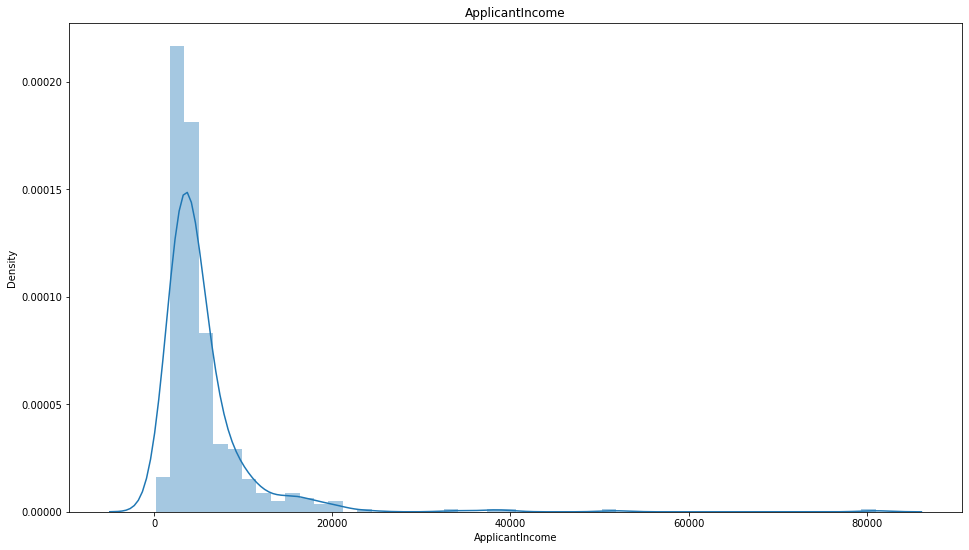

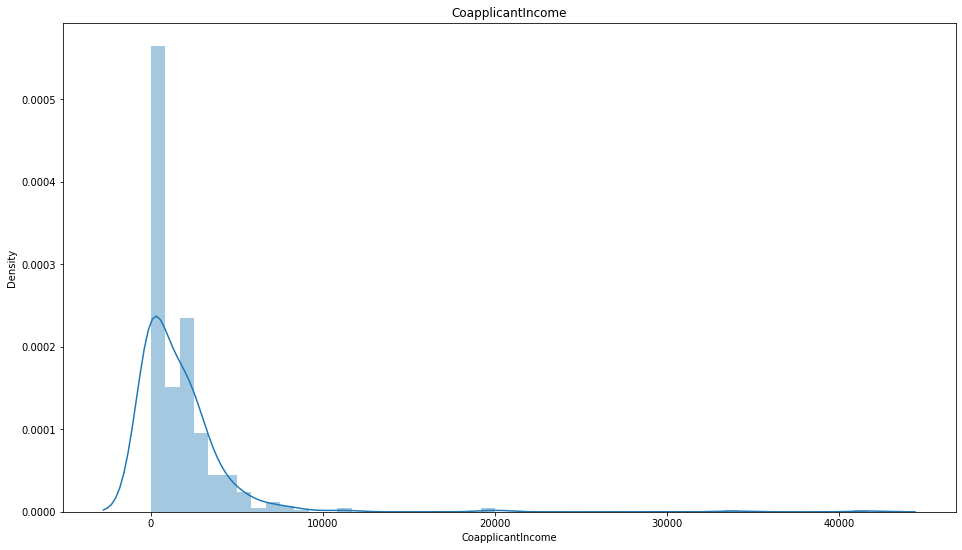

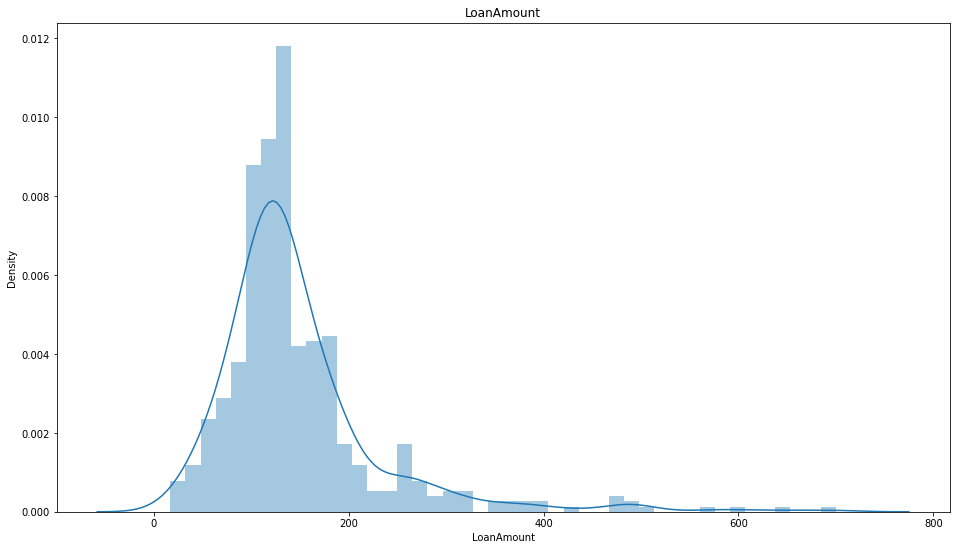

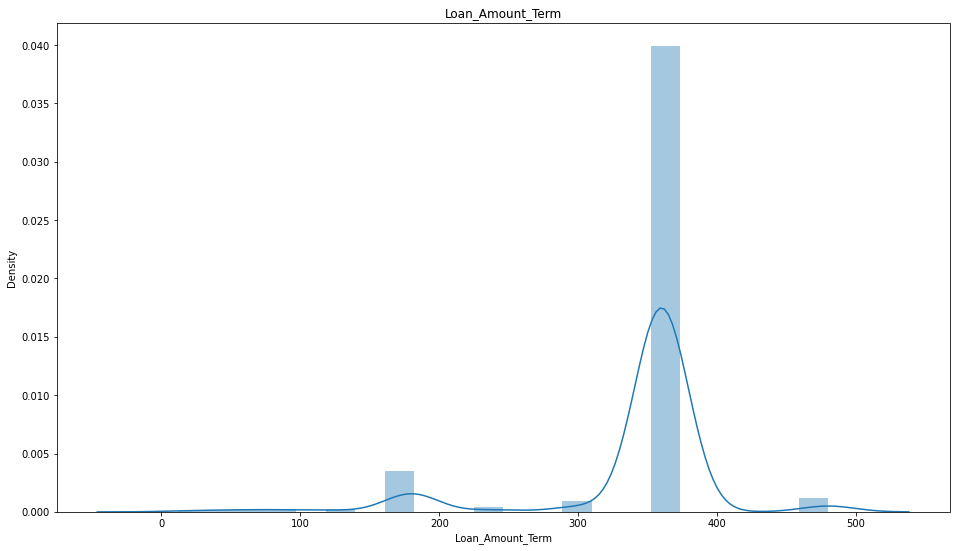

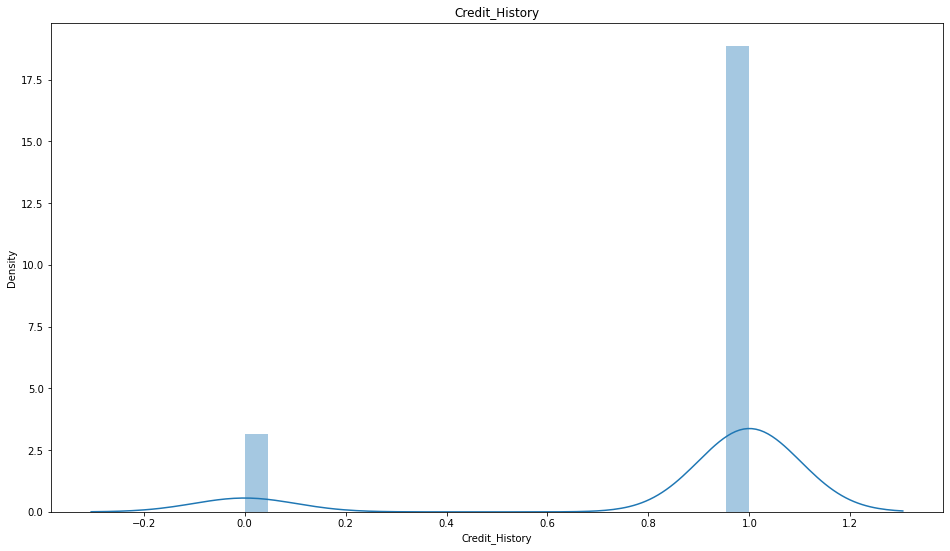

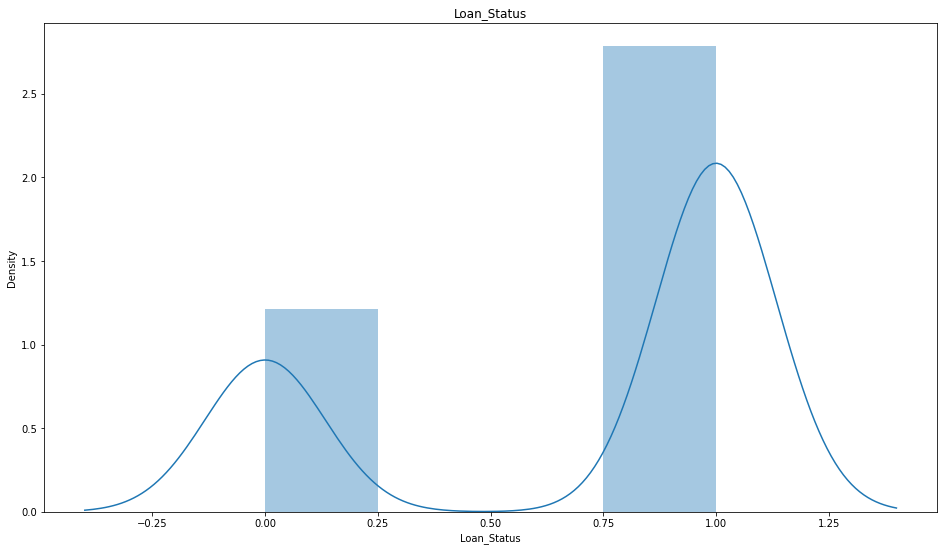

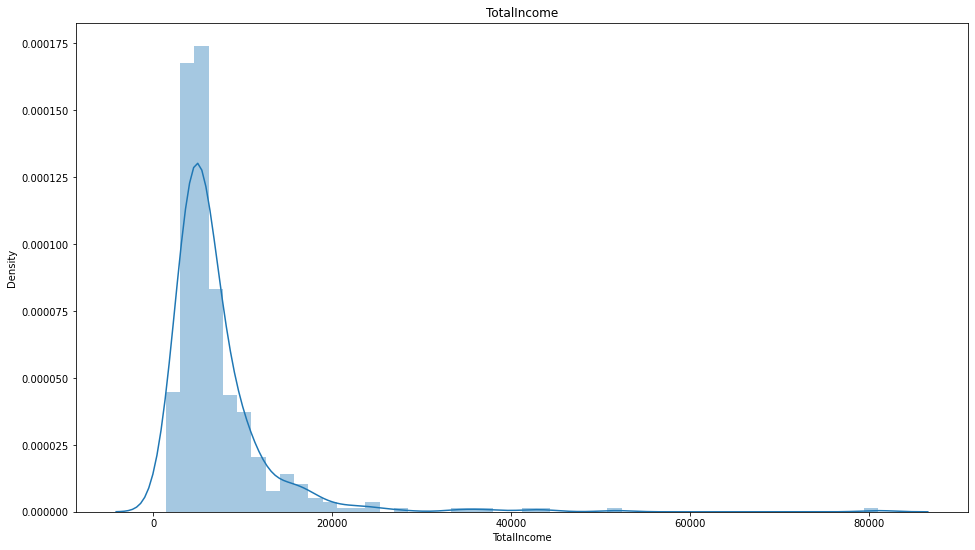

In [ ]:
for col in train_df_num.columns:
  plt.figure(figsize=(16, 9))
  sns.distplot(train_df_num[col])
  plt.title(col)
  plt.show()

In [ ]:
# Find skewed numerical features
numeric = []
for col in train_df_num.columns:
  numeric.append(col)

skew_features = train_df_num[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 4 numerical features with Skew > 0.5 :


CoapplicantIncome    7.231110
ApplicantIncome      6.511936
TotalIncome          5.445204
LoanAmount           2.661932
Loan_Status         -0.854970
Credit_History      -2.044641
Loan_Amount_Term    -2.333112
dtype: float64

In [ ]:
for i in skew_index:
  if skew_features[i] > 0:
    train_df_num[str(i)+"_log"] = np.log1p(train_df_num[i])
    if i in test_data.columns:
      test_data[str(i)+"_log"] = np.log1p(test_data[i])

# Combining the dataframes back into one dataframe

In [ ]:
print(train_df_num.shape)
print(train_df_obj.shape)
print(train_df_num.columns)
print(train_df_obj.columns)

(491, 11)
(491, 7)
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'TotalIncome',
       'CoapplicantIncome_log', 'ApplicantIncome_log', 'TotalIncome_log',
       'LoanAmount_log'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')


In [ ]:
train = pd.concat([train_df_num, train_df_obj], axis=1)
train

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,CoapplicantIncome_log,ApplicantIncome_log,TotalIncome_log,LoanAmount_log,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
83,6000,2250.0,265.0,360.0,1.0,0,8250.0,7.719130,8.699681,9.018090,5.583496,LP001273,Male,Yes,0,Graduate,No,Semiurban
90,2958,2900.0,131.0,360.0,1.0,1,5858.0,7.972811,7.992607,8.675734,4.882802,LP001316,Male,Yes,0,Graduate,No,Semiurban
227,6250,1695.0,210.0,360.0,1.0,1,7945.0,7.436028,8.740497,8.980424,5.351858,LP001758,Male,Yes,2,Graduate,No,Semiurban
482,2083,3150.0,128.0,360.0,1.0,1,5233.0,8.055475,7.642044,8.562931,4.859812,LP002537,Male,Yes,0,Graduate,No,Semiurban
464,4166,0.0,98.0,360.0,0.0,0,4166.0,0.000000,8.334952,8.334952,4.595120,LP002493,Male,No,0,Graduate,No,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1875,1875.0,97.0,360.0,1.0,1,3750.0,7.536897,7.536897,8.229778,4.584967,LP001245,Male,Yes,2,Not Graduate,Yes,Semiurban
106,11417,1126.0,225.0,360.0,1.0,1,12543.0,7.027315,9.342946,9.436998,5.420535,LP001369,Male,Yes,2,Graduate,No,Urban
270,3237,0.0,30.0,360.0,1.0,1,3237.0,0.000000,8.082711,8.082711,3.433987,LP001888,Female,No,0,Graduate,No,Urban
435,10047,0.0,129.0,240.0,1.0,1,10047.0,0.000000,9.215129,9.215129,4.867534,LP002393,Female,Yes,0,Graduate,No,Semiurban


In [ ]:
X_train_load_id = train['Loan_ID']
X_train = train.drop(['Loan_ID', 'Loan_Status'], axis='columns')
y_train = train['Loan_Status']

In [ ]:
print(X_train.shape)
print(y_train.shape)

(491, 16)
(491,)


In [ ]:
X_test_load_id = test_data['Loan_ID']
X_test = test_data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y_test = test_data['Loan_Status']

In [ ]:
print(X_test.shape)
print(y_test.shape)

(123, 16)
(123,)


In [ ]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [ ]:
X_train, X_test = X_train.align(X_test, join='inner', axis=1)  # inner join

In [ ]:
print(X_train.shape)
print(X_test.shape)

(491, 25)
(123, 25)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(491,)
(123,)


In [ ]:
X_train.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome',
       'CoapplicantIncome_log', 'ApplicantIncome_log', 'TotalIncome_log',
       'LoanAmount_log', 'Gender_Female', 'Gender_Male', 'Married_No',
       'Married_Yes', 'Dependents_3', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Education_Graduate', 'Education_Not Graduate',
       'Self_Employed_No', 'Self_Employed_Yes', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')

In [ ]:
X_test.head(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,CoapplicantIncome_log,ApplicantIncome_log,TotalIncome_log,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_3,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
350,9083,0.0,228.0,360.0,1.0,9083.0,0.000000,9.114270,9.114270,5.433722,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0
377,4310,0.0,130.0,360.0,1.0,4310.0,0.000000,8.368925,8.368925,4.875197,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0
163,4167,1447.0,158.0,360.0,1.0,5614.0,7.277939,8.335192,8.633197,5.068904,0,1,0,1,0,0,0,1,1,0,1,0,1,0,0
609,2900,0.0,71.0,360.0,1.0,2900.0,0.000000,7.972811,7.972811,4.276666,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0
132,2718,0.0,70.0,360.0,1.0,2718.0,0.000000,7.908019,7.908019,4.262680,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0
578,1782,2232.0,107.0,360.0,1.0,4014.0,7.711101,7.486053,8.297793,4.682131,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0
316,3717,0.0,120.0,360.0,1.0,3717.0,0.000000,8.220941,8.220941,4.795791,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0
2,3000,0.0,66.0,360.0,1.0,3000.0,0.000000,8.006701,8.006701,4.204693,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
340,2647,1587.0,173.0,360.0,1.0,4234.0,7.370231,7.881560,8.351139,5.159055,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0
77,1000,3022.0,110.0,360.0,1.0,4022.0,8.014005,6.908755,8.299783,4.709530,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1


# Modelling (Base model)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc_score)

Accuracy score:  0.7235772357723578


Using the baseline model above, we will use the Stratified K Fold Cross Validation approach to improve our models. Specifically, we will use several other models to perform this classification task.

In [ ]:
i = 1
mean = []

kfold = StratifiedKFold(n_splits=5, random_state=1)
for train_idx, test_idx in kfold.split(X_train, y_train):
  # print(train_idx)
  x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

  logreg = LogisticRegression(random_state=1)
  logreg.fit(x_tr, y_tr)
  
  predictions = logreg.predict(x_val)
  acc_score = accuracy_score(y_val, predictions)
  print("Score: ", acc_score)

  i += 1

  mean.append(acc_score)

mean_val_score = sum(mean) / len(mean)
print("Mean validation score: ", mean_val_score)

Score:  0.7878787878787878
Score:  0.7346938775510204
Score:  0.7551020408163265
Score:  0.7653061224489796
Score:  0.7244897959183674
Mean validation score:  0.7534941249226963


# Feature Engineering

In [ ]:
train.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'TotalIncome',
       'CoapplicantIncome_log', 'ApplicantIncome_log', 'TotalIncome_log',
       'LoanAmount_log', 'Loan_ID', 'Gender', 'Married', 'Dependents',
       'Education', 'Self_Employed', 'Property_Area'],
      dtype='object')

Compared to the other features that tell us what the situation of the applicant is in, we still haven't seen whether he/she is able to actually repay the loan each month, so let's do that. 

In [ ]:
train['Loan_Repayment_Per_Month'] = train['LoanAmount'] / train['Loan_Amount_Term']
test_data['Loan_Repayment_Per_Month'] = test_data['LoanAmount'] / test_data['Loan_Amount_Term']

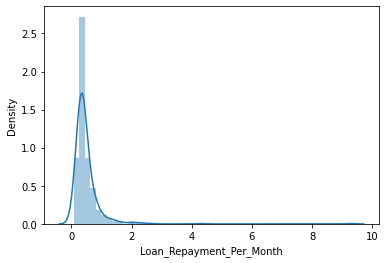

In [ ]:
sns.distplot(train['Loan_Repayment_Per_Month'])

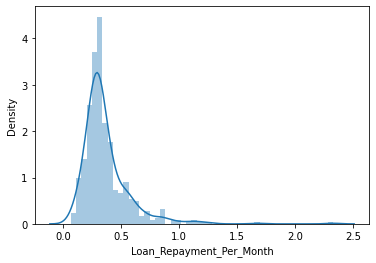

In [ ]:
# Log transform it
train['Loan_Repayment_Per_Month'] = np.log1p(train['Loan_Repayment_Per_Month'])
test_data['Loan_Repayment_Per_Month'] = np.log1p(test_data['Loan_Repayment_Per_Month'])

sns.distplot(train['Loan_Repayment_Per_Month'])

In [ ]:
train.drop(['LoanAmount', 'Loan_Amount_Term'], axis=1, inplace=True)
test_data.drop(['LoanAmount', 'Loan_Amount_Term'], axis=1, inplace=True)

After repaying the loan each month, does the applicant have enough to live?

In [ ]:
train['Balance_Income'] = train['TotalIncome'] - (train['Loan_Repayment_Per_Month'] * 1000)
test_data['Balance_Income'] = test_data['TotalIncome'] - (test_data['Loan_Repayment_Per_Month'] * 1000)

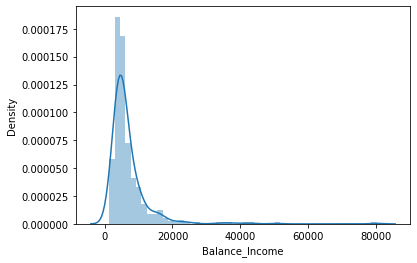

In [ ]:
sns.distplot(train['Balance_Income'])

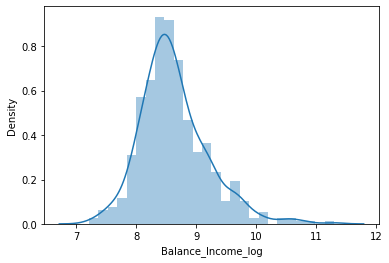

In [ ]:
train['Balance_Income_log'] = np.log1p(train['Balance_Income'])
test_data['Balance_Income_log'] = np.log1p(test_data['Balance_Income'])

sns.distplot(train['Balance_Income_log'])

In [ ]:
train.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'Loan_Status',
       'TotalIncome', 'CoapplicantIncome_log', 'ApplicantIncome_log',
       'TotalIncome_log', 'LoanAmount_log', 'Loan_ID', 'Gender', 'Married',
       'Dependents', 'Education', 'Self_Employed', 'Property_Area',
       'Loan_Repayment_Per_Month', 'Balance_Income', 'Balance_Income_log'],
      dtype='object')

In [ ]:
len(train.columns) == len(test_data.columns)

True

In [ ]:
train.drop(['ApplicantIncome', 'ApplicantIncome_log', 'CoapplicantIncome', 'CoapplicantIncome_log', 'TotalIncome', 'Balance_Income'], axis=1, inplace=True)
test_data.drop(['ApplicantIncome', 'ApplicantIncome_log', 'CoapplicantIncome', 'CoapplicantIncome_log', 'TotalIncome', 'Balance_Income'], axis=1, inplace=True)

# Modelling (4 models)

- Logistic Regression
- Random Forest
- Decision Tree
- XGBoost

In [ ]:
X_train = train.drop(['Loan_ID', 'Loan_Status'], axis=1)
y_train = train['Loan_Status']

X_test = test_data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y_test = test_data['Loan_Status']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(491, 11)
(491,)
(123, 11)
(123,)


In [ ]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [ ]:
X_train, X_test = X_train.align(X_test, join='inner', axis=1)  # inner join

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(491, 20)
(491,)
(123, 20)
(123,)


In [ ]:
y_train.value_counts()

1    342
0    149
Name: Loan_Status, dtype: int64

1. Logistic Regression

In [ ]:
i = 1
mean = []

kfold = StratifiedKFold(n_splits=5, random_state=1)
for train_idx, test_idx in kfold.split(X_train, y_train):
  # print(train_idx)
  x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

  logreg = LogisticRegression(random_state=1)
  logreg.fit(x_tr, y_tr)
  
  predictions = logreg.predict(x_val)
  acc_score = accuracy_score(y_val, predictions)
  print("Score: ", acc_score)

  pred = logreg.predict_proba(x_val)[:,1]

  i += 1

  mean.append(acc_score)

mean_val_score = sum(mean) / len(mean)
print("Mean validation score: ", mean_val_score)

Score:  0.8484848484848485
Score:  0.8061224489795918
Score:  0.8163265306122449
Score:  0.7857142857142857
Score:  0.8061224489795918
Mean validation score:  0.8125541125541125


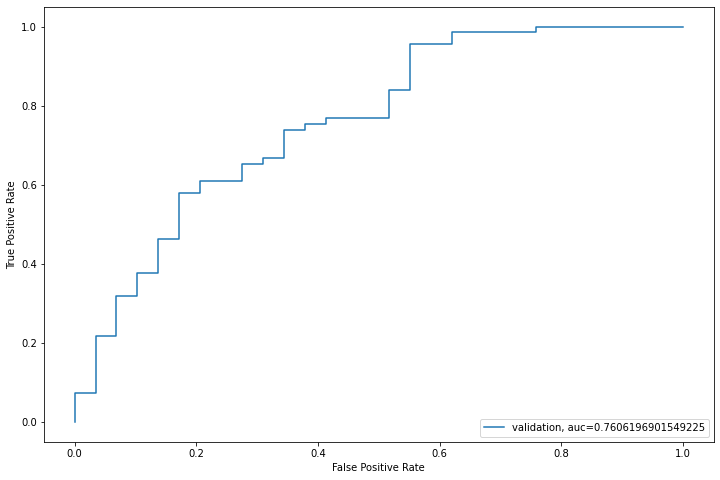

In [ ]:
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

2. Decision Tree

In [ ]:
i = 1
mean = []

kfold = StratifiedKFold(n_splits=5, random_state=1)
for train_idx, test_idx in kfold.split(X_train, y_train):
  # print(train_idx)
  x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

  dec_tree = tree.DecisionTreeClassifier(random_state=1)
  dec_tree.fit(x_tr, y_tr)
  
  predictions = dec_tree.predict(x_val)
  acc_score = accuracy_score(y_val, predictions)
  print("Score: ", acc_score)

  pred = dec_tree.predict_proba(x_val)[:,1]

  i += 1

  mean.append(acc_score)

mean_val_score = sum(mean) / len(mean)
print("Mean validation score: ", mean_val_score)

Score:  0.7474747474747475
Score:  0.6836734693877551
Score:  0.6836734693877551
Score:  0.7346938775510204
Score:  0.7755102040816326
Mean validation score:  0.7250051535765821


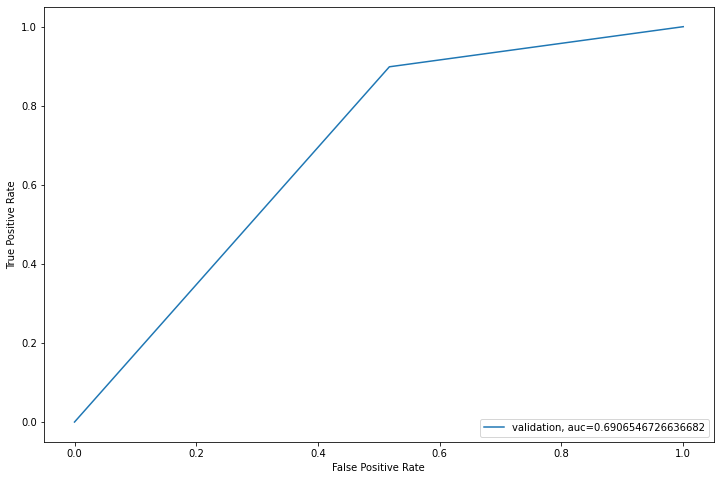

In [ ]:
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

3. Random Forest

In [ ]:
i = 1
mean = []

kfold = StratifiedKFold(n_splits=5, random_state=1)
for train_idx, test_idx in kfold.split(X_train, y_train):
  # print(train_idx)
  x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

  rf = RandomForestClassifier(random_state=1, max_depth=10)
  rf.fit(x_tr, y_tr)
  
  predictions = rf.predict(x_val)
  acc_score = accuracy_score(y_val, predictions)
  print("Score: ", acc_score)

  pred = rf.predict_proba(x_val)[:,1]

  i += 1

  mean.append(acc_score)

mean_val_score = sum(mean) / len(mean)
print("Mean validation score: ", mean_val_score)

Score:  0.8686868686868687
Score:  0.7551020408163265
Score:  0.8163265306122449
Score:  0.7857142857142857
Score:  0.8061224489795918
Mean validation score:  0.8063904349618636


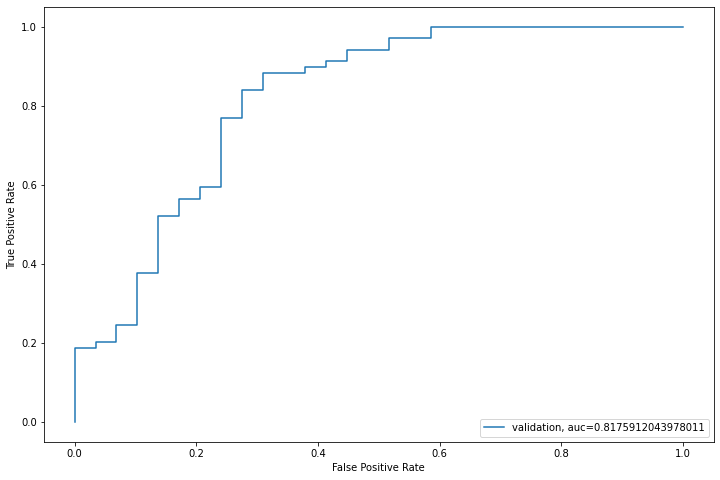

In [ ]:
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

4. Grid Search for Random Forest

In [ ]:
param_grid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=param_grid)
x_tr, x_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

grid_search.fit(x_tr, y_tr)
print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [ ]:
i = 1
mean = []

kfold = StratifiedKFold(n_splits=5, random_state=1)
for train_idx, test_idx in kfold.split(X_train, y_train):
  # print(train_idx)
  x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

  rf = RandomForestClassifier(random_state=1, max_depth=9, n_estimators=21)
  rf.fit(x_tr, y_tr)
  
  predictions = rf.predict(x_val)
  acc_score = accuracy_score(y_val, predictions)
  print("Score: ", acc_score)

  pred = rf.predict_proba(x_val)[:,1]

  i += 1

  mean.append(acc_score)

mean_val_score = sum(mean) / len(mean)
print("Mean validation score: ", mean_val_score)

Score:  0.8282828282828283
Score:  0.7653061224489796
Score:  0.8061224489795918
Score:  0.7857142857142857
Score:  0.8061224489795918
Mean validation score:  0.7983096268810554


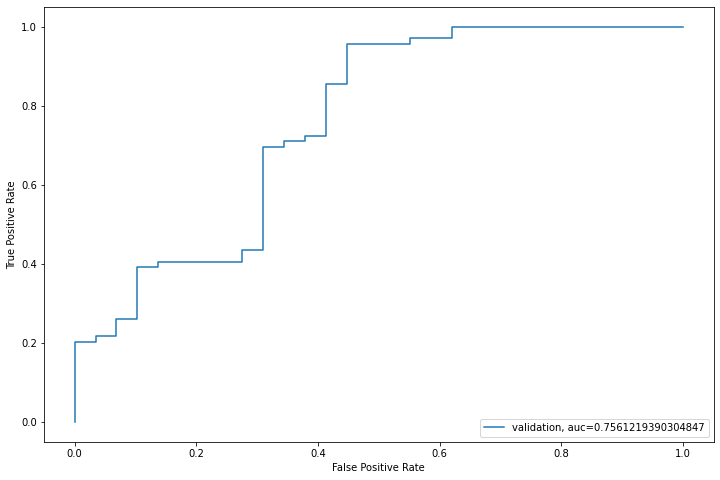

In [ ]:
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

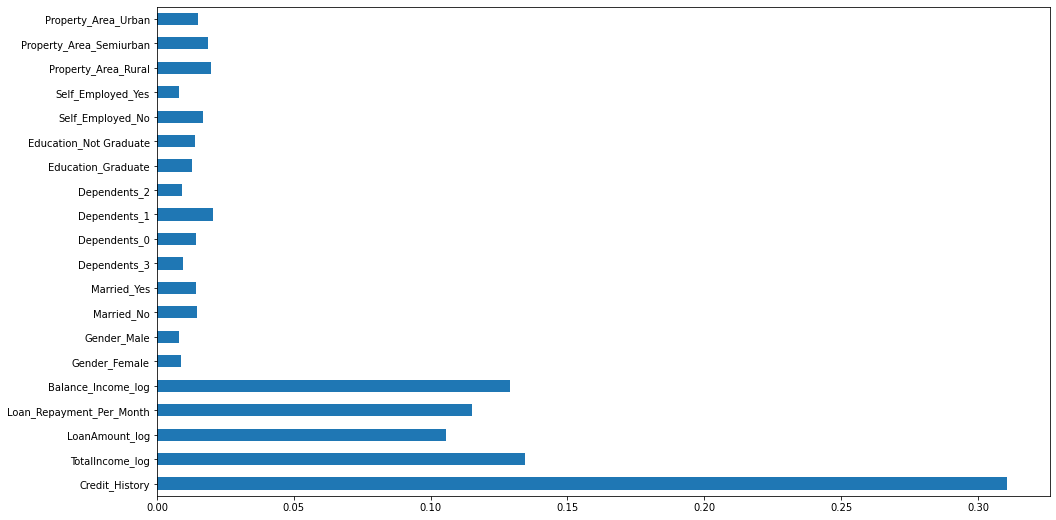

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.plot(kind='barh', figsize=(16, 9))

5. XGBoost

In [ ]:
i = 1
mean = []

kfold = StratifiedKFold(n_splits=5, random_state=1)
for train_idx, test_idx in kfold.split(X_train, y_train):
  # print(train_idx)
  x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

  xgb = XGBClassifier(random_state=1, max_depth=4, n_estimators=50)
  xgb.fit(x_tr, y_tr)
  
  predictions = xgb.predict(x_val)
  acc_score = accuracy_score(y_val, predictions)
  print("Score: ", acc_score)

  pred = xgb.predict_proba(x_val)[:,1]

  i += 1

  mean.append(acc_score)

mean_val_score = sum(mean) / len(mean)
print("Mean validation score: ", mean_val_score)

Score:  0.8585858585858586
Score:  0.7448979591836735
Score:  0.8163265306122449
Score:  0.7551020408163265
Score:  0.8163265306122449
Mean validation score:  0.7982477839620696


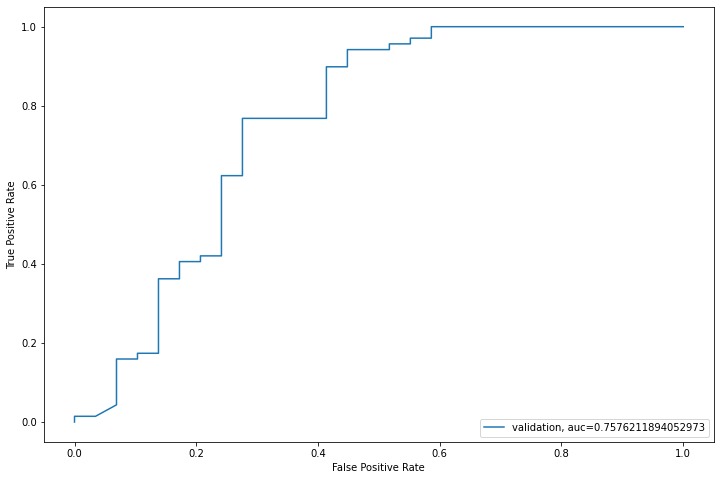

In [ ]:
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

From all the models, it seems that the Logistic Regression performs best with an average accuracy score of 81%.

# Using Logistic Regression on our own test set

In [ ]:
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

acc_score = accuracy_score(y_test, predictions)
print("Accuracy score: ", acc_score)

Accuracy score:  0.7886178861788617


In [ ]:
submission = pd.DataFrame({'Loan_ID': X_test_load_id, 'Loan_Status': predictions})
submission.head(10)

,Loan_ID,Loan_Status
350,LP002139,1
377,LP002223,1
163,LP001570,1
609,LP002978,1
132,LP001478,1
578,LP002877,1
316,LP002035,1
2,LP001005,1
340,LP002115,1
77,LP001259,1


In [ ]:
submission['Loan_Status'].value_counts()

1    104
0     19
Name: Loan_Status, dtype: int64

# Using Logistic Regression on the given test set for submission

In [ ]:
test_original = pd.read_csv(test_csv)

In [ ]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [ ]:
test_df_num = test_original.select_dtypes(include=['int64', 'float64'], exclude=['object'])
test_df_obj = test_original.select_dtypes(include=['object'], exclude=['int64', 'float64'])

Handling missing data

In [ ]:
total_null = test_original.isnull().sum().sort_values(ascending=False)
percent_null = (test_original.isnull().sum() / test_original.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent
Credit_History,29,0.079019
Self_Employed,23,0.062670
Gender,11,0.029973
Dependents,10,0.027248
Loan_Amount_Term,6,0.016349
LoanAmount,5,0.013624


In [ ]:
test_original['Credit_History'].fillna(train_df_num['Credit_History'].mode()[0], inplace=True)
test_original['Self_Employed'].fillna(train_df_obj['Self_Employed'].mode()[0], inplace=True)
test_original['Dependents'].fillna(train_df_obj['Dependents'].mode()[0], inplace=True)
test_original['Gender'].fillna(train_df_obj['Gender'].mode()[0], inplace=True)
test_original['LoanAmount'].fillna(train_df_num['LoanAmount'].median(), inplace=True)
test_original['Loan_Amount_Term'].fillna(train_df_num['Loan_Amount_Term'].median(), inplace=True)

In [ ]:
total_null = test_original.isnull().sum().sort_values(ascending=False)
percent_null = (test_original.isnull().sum() / test_original.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

,Total,Percent


In [ ]:
test_original['Dependents'].replace('3+', 3, inplace=True)

Fixing skewness

In [ ]:
skew_index

Index(['CoapplicantIncome', 'ApplicantIncome', 'TotalIncome', 'LoanAmount'], dtype='object')

In [ ]:
test_original['TotalIncome'] = test_original['ApplicantIncome'] + test_original['CoapplicantIncome']

In [ ]:
for i in skew_index:
  if skew_features[i] > 0 and i != 'Loan_Status':
    test_original[str(i)+"_log"] = np.log1p(test_original[i])

In [ ]:
test_original['Loan_Repayment_Per_Month'] = test_original['LoanAmount'] / test_original['Loan_Amount_Term']
test_original['Loan_Repayment_Per_Month'] = np.log1p(test_original['Loan_Repayment_Per_Month'])
test_original.drop(['LoanAmount', 'Loan_Amount_Term'], axis=1, inplace=True)

test_original['Balance_Income'] = test_original['TotalIncome'] - (test_original['Loan_Repayment_Per_Month'] * 1000)
test_original['Balance_Income_log'] = np.log1p(test_original['Balance_Income'])
test_original.drop(['Balance_Income'], axis=1, inplace=True)

In [ ]:
features_to_drop = ['ApplicantIncome', 'ApplicantIncome_log', 'CoapplicantIncome', 'CoapplicantIncome_log', 'TotalIncome', 'Balance_Income']
for col in test_original.columns:
  if col in features_to_drop:
    test_original.drop([col], axis=1, inplace=True)

In [ ]:
test_original = pd.get_dummies(test_original)

In [ ]:
_, test_original = X_train.align(test_original, join='inner', axis=1)  # inner join

In [ ]:
print(test_original.shape)
print(X_train.shape)

(367, 20)
(491, 20)


In [ ]:
print(test_original.columns)
print(X_train.columns)

Index(['Credit_History', 'TotalIncome_log', 'LoanAmount_log',
       'Loan_Repayment_Per_Month', 'Balance_Income_log', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_3',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')
Index(['Credit_History', 'TotalIncome_log', 'LoanAmount_log',
       'Loan_Repayment_Per_Month', 'Balance_Income_log', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_3',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')


In [ ]:
predictions = logreg.predict(test_original)

In [ ]:
test_again = pd.read_csv(test_csv)
test_id = test_again['Loan_ID']

submission = pd.DataFrame({'Loan_ID': test_id, 'Loan_Status': predictions})
submission.head(10)

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1
5,LP001054,1
6,LP001055,1
7,LP001056,0
8,LP001059,1
9,LP001067,1


In [ ]:
submission.to_csv("/content/drive/My Drive/Fusionex Internship/Classification/loan_eligibility_logreg_submission.csv")

# Things I Learnt


Classification
1. Standardization does not fix skewness.
2. Normalization does not handle outliers well since the outliers will be scaled down to between 0-1.
3. Normalization forces data to follow a Gaussian distribution. Standardization is usually used when the data is already following a Gaussian distribution, hence centering around the mean (0) with unit std dev (1).
4. Since we are using tree-based algorithms, standardization/normalization does not help much as these models are insensitive to the scale of the features.

--------------------------------------------------------------------------

1. It's fine to make assumptions and plot graphs feature by feature. To make things neater, plot graphs side by side or in the same figure to make clear comparisons.
2. When the number of features are manageable, plotting graphs feature by feature is still a good way. Otherwise, insights might be lost as we inspect more features.
3. When separating data into bins, make use of the quantile range, though manually assigning ranges is somewhat a quicker way.
4. When visualizing the performance of the models, make use of classification report and confusion matrix where the numbers tell a better story instead of just accuracy. Again, accuracy is not always the best metric for classification tasks.
5. If you have multiple models, make a table comparing the performances of each model for easy visualization.
6. Depending on the goal of the task, tweaking the threshold for classification is important. In this loan eligibility task, the threshold for loan approvals is usually lower than 0.5.